In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
import warnings
from itertools import product
import numpy as np 

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
%matplotlib inline

In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


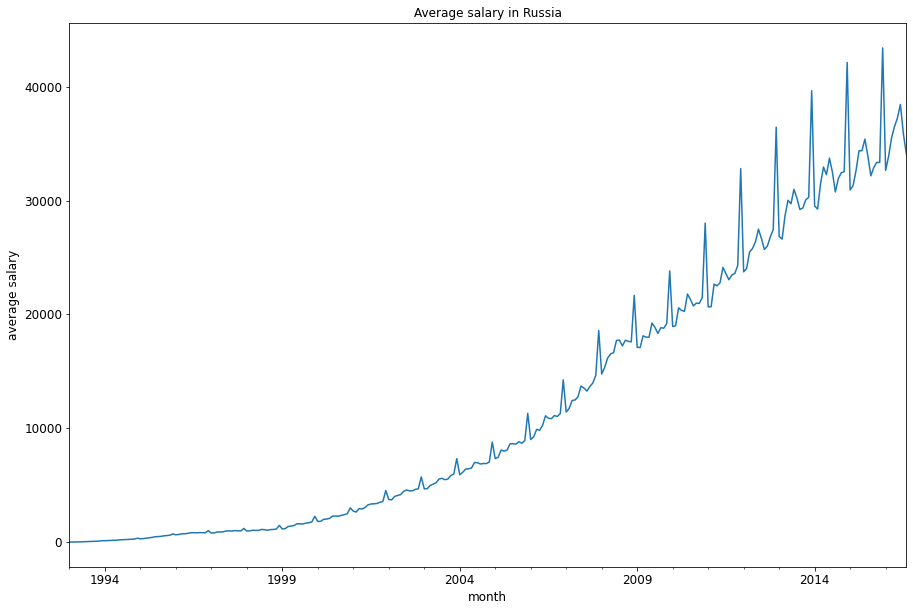

In [4]:
salary.rename(columns={'WAG_C_M': 'salary_rub'}, inplace=True)
salary.salary_rub.plot(figsize=(15, 10), title='Average salary in Russia', fontsize=12);
plt.xlabel('month', fontsize=12)
plt.ylabel('average salary', fontsize=12)
plt.show()

В рамках первичной визуалиции можно сразу отметить восходящий общий тренд. Сезонность с пиками в декабре и падением в январе(годовые премии). Рост дисперсии. Со всем этим нужно будет отдельно проанализировать

Критерий Дики-Фуллера: p=0.991850


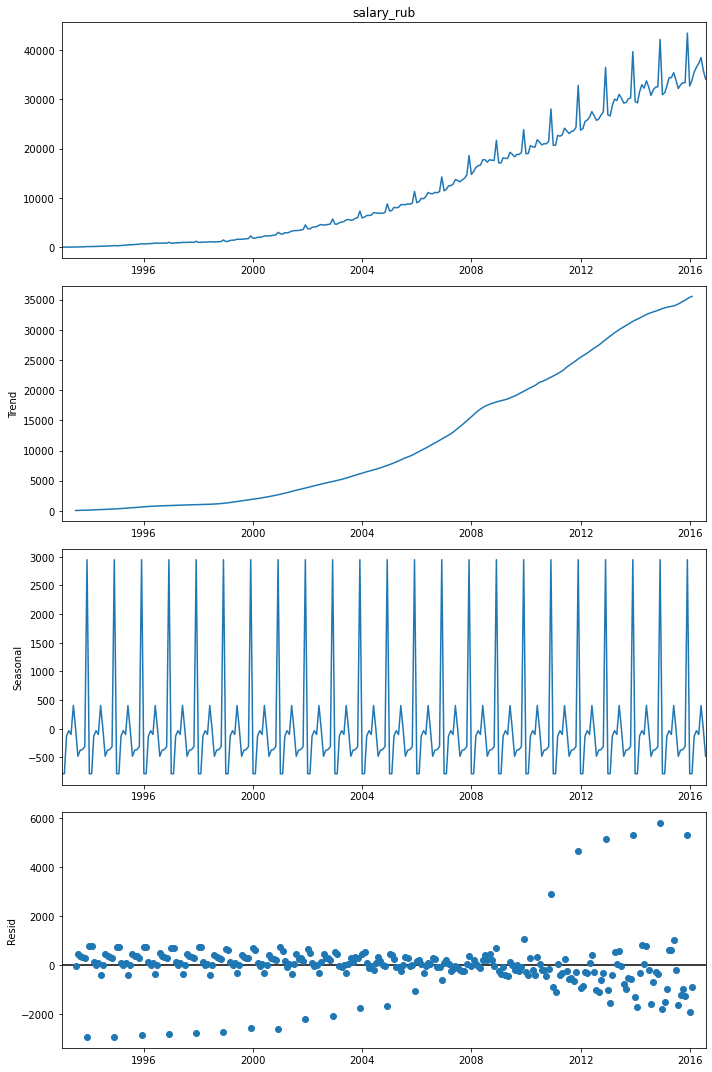

In [5]:
# Проверка стационарности и STL-декомпозиция ряда:
plt.rcParams["figure.figsize"] = (10,15)

sm.tsa.seasonal_decompose(salary.salary_rub).plot( )
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_rub)[1])

# Гипотеза о стационарности критерием Дики- Фуллера не потверждается. Но подождите тут ведь еще тренд и сезонность

# Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


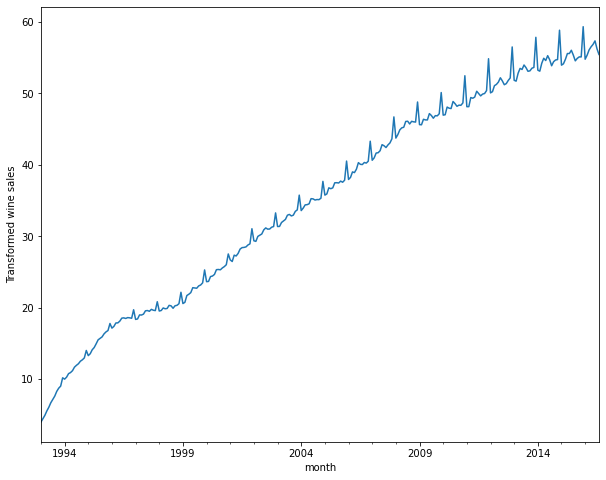

In [6]:
plt.rcParams["figure.figsize"] = (10,8)
salary['salary_box'], lmbda = stats.boxcox(salary.salary_rub)

salary.salary_box.plot()
plt.ylabel('Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

# Стационарность
Попробуем сезонное дифференцирование - чтобы избавиться от тренда

Критерий Дики-Фуллера: p=0.014697


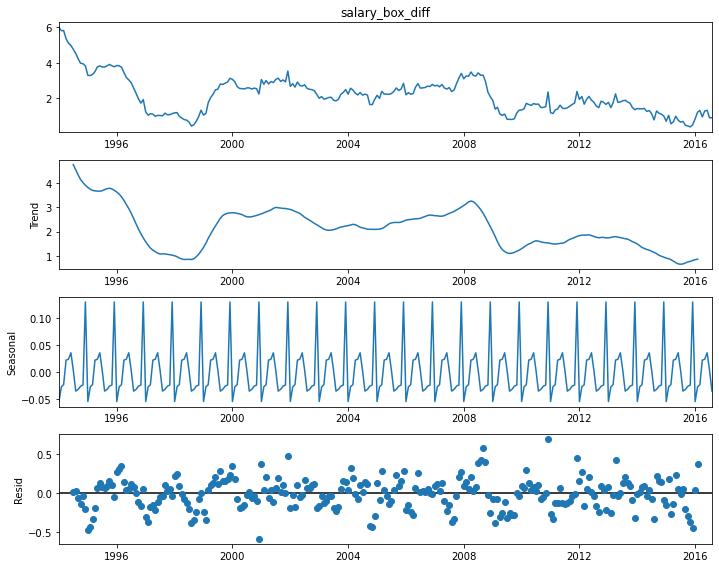

In [7]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)

sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


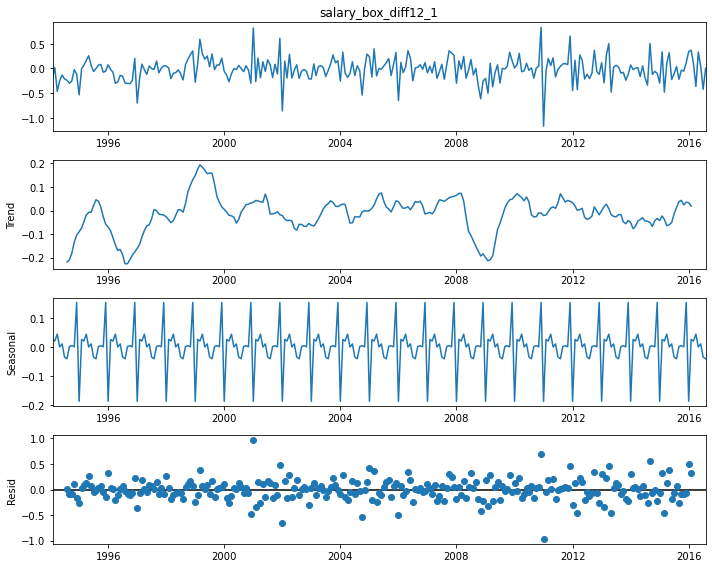

In [8]:
# Годовое диффернцирование не помогло, нужно еще раз

salary['salary_box_diff12_1'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
sm.tsa.seasonal_decompose(salary.salary_box_diff12_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff12_1[13:])[1])

In [9]:
salary.salary_box_diff = salary.salary_box_diff12_1
salary.drop('salary_box_diff12_1', axis=1, inplace=True)

# SARIMA

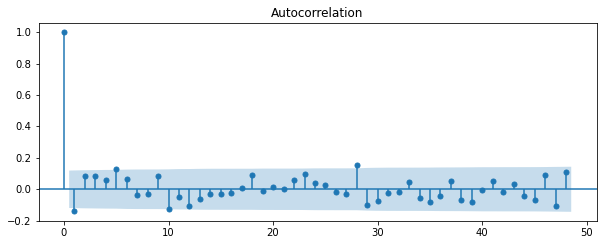

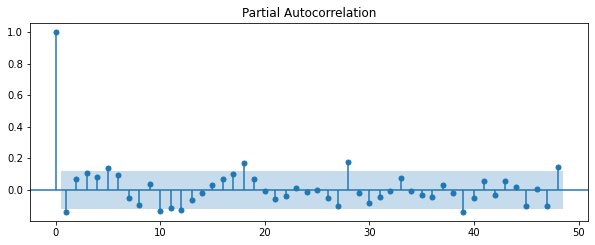

In [10]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 18

сезонных лагов со значимой корреляцией нет, значит, начальное приближение Q = 0

In [11]:
ps = range(0, 19)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

76

In [ ]:

%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
esult_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())